In [1]:
# conda install -c conda-forge xgboost

In [2]:
# pip install xgboost

In [3]:
# Import the libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, plot_tree
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
#Import the fraud dataset into a panda dataframe and rename mismatched column names
df = pd.read_csv('data/fraud_data.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [5]:
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [6]:
#Check for any null values in the data
df.isnull().values.any()

False

In [7]:
# The dataset does have a flag indicating whether a transaction was fraudulet or not 
# and interestingly enough it correlates very well with the number of cash out transactions 
# - basically implying that quick transfer ins and cash outs are a good
# early indicator of potential fraudulent transactions

print('The types of fraudulent transactions are {}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) 

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

# print(format(len(dfFraudTransfer)))
# print(format(len(dfFraudCashout)))

print('The number of fraudulent TRANSFERs = {}'.format(len(dfFraudTransfer))) 
print('The number of fraudulent CASH_OUTs = {}'.format(len(dfFraudCashout))) 

The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']
The number of fraudulent TRANSFERs = 4097
The number of fraudulent CASH_OUTs = 4116


In [8]:
# Clean the data to narrow it down to the Transfer and Cash out type of transactions and discard meaningless
# or inconsistently populated columns like nameOrig, nameDest and isFlaggedFraud

X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis 
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

In [9]:
#Since the destination account having zero balance after the transfer in cash out, let's mark it more prominently
#so it is easier for our machine learning model to detect this type of final balance and we will create a specific
#feature around this point for model training

X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), ['oldBalanceDest', 'newBalanceDest']] = - 1
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), ['oldBalanceOrig', 'newBalanceOrig']] = np.nan
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

In [10]:
#visualize our data to see if we can see fraudulent transactions more clearly
limit = len(X)

def plotStrip(x, y, hue, figsize = (15, 10)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(1, 2, 8))
    with sns.axes_style('whitegrid'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.5, marker = '.', \
             size = 4, palette = 'colorblind')
        ax.set_xlabel('')
        ax.set_xticklabels(['regular tx', 'fraudulent tx'], size = 18)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, fontsize = 15);
    return ax

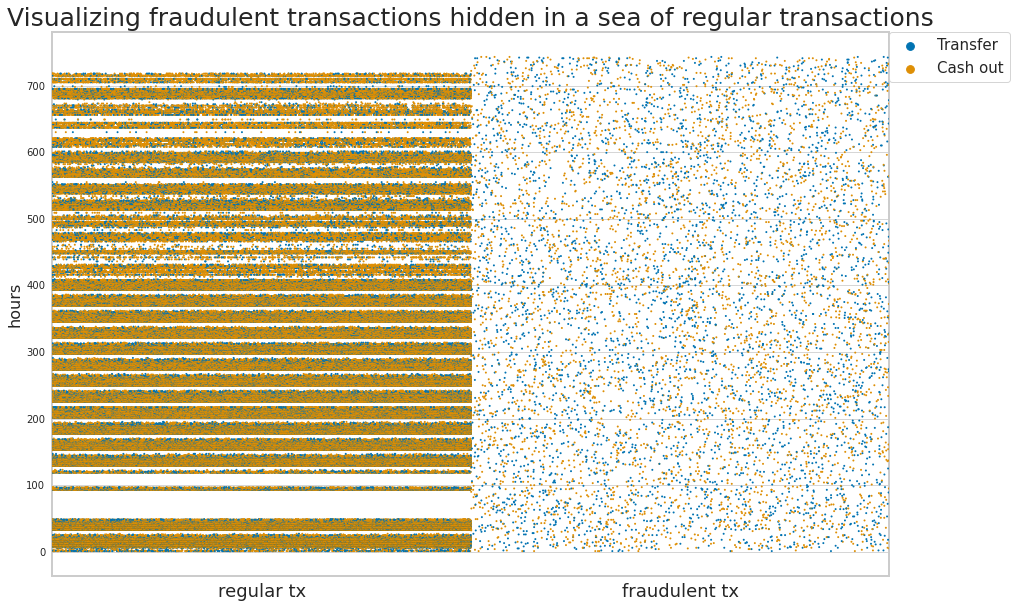

In [11]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('hours', size = 16)
ax.set_title('Visualizing fraudulent transactions hidden in a sea of regular transactions', size = 25);